In [2]:
import math
from scipy.optimize import minimize
from scipy.optimize import Bounds
import matplotlib.pyplot as pyplot
import numpy
import json

In [3]:
def PMF_logbinomial(theta, n, k):
    return k*numpy.log(theta) + (n-k)*numpy.log(1-theta)

def negativa_PMF_logbinomial(theta, n, k):
    ll = k*numpy.log(theta) + (n-k)*numpy.log(1-theta)
    return -ll

In [4]:
n = 10
k = 9
# theta es incógnita

C:\Users\Midriffy\AppData\Local\Temp\ipykernel_6388\3555940352.py:2: RuntimeWarning: divide by zero encountered in log
  return k*numpy.log(theta) + (n-k)*numpy.log(1-theta)


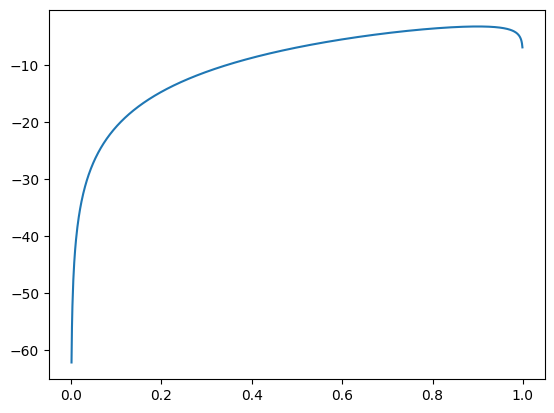

In [5]:
# Sacamos theta por fuerza bruta
paso = 0.001
thetas = numpy.linspace(0, 1, int(1/paso))
log_like = PMF_logbinomial(thetas, n, k)
pyplot.plot(thetas, log_like)

In [5]:
arg_max_idx = numpy.argmax(log_like)
print(f"theta que maximiza: {thetas[arg_max_idx]} (precisión: {int(1/paso)})")

theta que maximiza: 0.8998998998998999 (precisión: 1000)


In [6]:
# Vemos qué hace la función minimize:
# Parámetros:
# - fun = una función matemática cuyo primer parámetro sea un vector, y el resto, parámetros fijos.
#   Aquí, la n de PMF_logbinomial(n, k, theta) es mi vector de valores, y la k y theta son parámetros fijos.
# - method = algoritmo a usar para minimizar
#   Para la clase uisaremos "Nelder-Mead" y "L-BFGS-B"
#help(minimize)

In [7]:
# Ahora sacamos theta por método de máxima verosimilitud
n = 10
k = 9
theta_inicial = 0.3
resultao = minimize(negativa_PMF_logbinomial, x0=theta_inicial, args=(n,k), method="Nelder-Mead", bounds=[(0.00001, 0.99999)])

In [8]:
resultao

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.2508297339144825
             x: [ 9.000e-01]
           nit: 18
          nfev: 36
 final_simplex: (array([[ 9.000e-01],
                       [ 8.999e-01]]), array([ 3.251e+00,  3.251e+00]))

In [9]:
# Ahora probamos con la distribución de Weibull
# Un equipo de control de calidad de Denso Wave ha probado 150 unidades de un componente electrónico hasta que falla, registrando el tiempo de vida de cada uno en horas. Modelamos esa distribución para hacer predicciones como estimar la vida media del componente.
# La distribución de Weibull tiene por parámetros:
# k = tipo de falla
#     k < 1 -> fallas que disminuyen con el tiempo ("fallas infantiles")
#     k > 1 -> fallas que aumentan con el tiempo (e.g. fallas por desgaste)
#     k = 1 -> probabilidad constante, hará que la distribución de Weibull se convierta en exponencial
# lambda = vida característica del componente
# Fórmula:
#     f(x, k, lambda) = (k/lambda)(x/lambda)^(k-1) * e^(-(x/lambda)^k)
# donde x >= 0

In [10]:
from scipy.stats import weibull_min
numpy.random.seed(297974)
k_verdadera = 2.5
lambda_verdadera = 1000
tamanio_muestra = 100000
tiempos_falla = weibull_min.rvs(c=k_verdadera, scale=lambda_verdadera, size=tamanio_muestra)

#pyplot.hist(tiempos_falla, bins=50)

In [11]:
# Definimos la función de log-verosimilitud negativa
def negativa_log_verosimilitud_weibull(tupla_parametros, x):
    # no puedo usar "lambda" porque f(x) = x^2 en Python se escribe lambda x: x ** 2
    k, lambda_ = tupla_parametros
    if k <= 0 or lambda_ <= 0:
        return numpy.inf
    LL = numpy.sum(numpy.log(k) - numpy.log(lambda_) + (k-1)*(numpy.log(x)-numpy.log(lambda_)) - (x/lambda_)**k)
    return -LL

In [12]:
k_inicial = 1
lambda_inicial = 500
params_iniciales = (k_inicial, lambda_inicial)
limites = ( (0.000001, None), (0.000001, None) )
x = tiempos_falla

# El resultado sale en x y es la tupla (k, lambda)
resultao = minimize(negativa_log_verosimilitud_weibull, x0=params_iniciales, args=(x,), method="L-BFGS-B", bounds=limites)
resultao

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 734303.8133755886
        x: [ 2.483e+00  1.000e+03]
      nit: 23
      jac: [ 1.164e-01  4.657e-02]
     nfev: 75
     njev: 25
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [13]:
# Comparamos ahora el resultado con lo que originalmente saqué
k_gorrito, lambda_gorrito = resultao.x
print(f"k original = {k_verdadera}, k estimada = {k_gorrito}, diferencia: {k_verdadera - k_gorrito}")
print(f"lambda original = {lambda_verdadera}, k estimada = {lambda_gorrito}, diferencia: {lambda_verdadera - lambda_gorrito}")

k original = 2.5, k estimada = 2.483357568486877, diferencia: 0.016642431513123057
lambda original = 1000, k estimada = 1000.2861412840966, diferencia: -0.28614128409662953


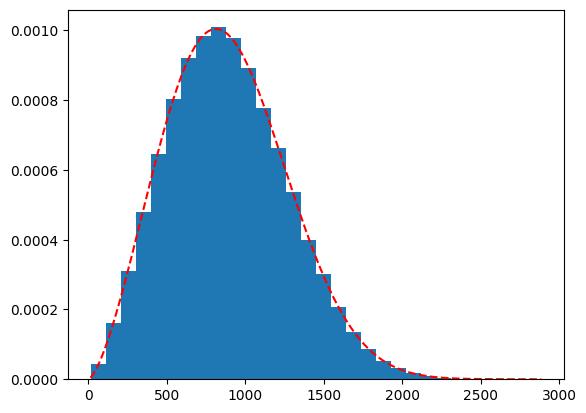

In [14]:
# Confirmamos qué tan precisamente estimamos nuestros parámetros encimando la PDF encima de nuestro histograma
pyplot.hist(tiempos_falla, density=True, bins=30)
eje_X = numpy.linspace(tiempos_falla.min(), tiempos_falla.max(), 200)
pdf_ajustada = weibull_min.pdf(eje_X, c=k_gorrito, scale=lambda_gorrito)
pyplot.plot(eje_X, pdf_ajustada, "r--")